# Lab 5 Report:
## Create Arthur Conan Doyle AI with RNN

### Name:

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Prepare Data

In [5]:
# You will train on the first N characters of the Sherlock Holmes book
# Pick the size of your training data, i.e. N
data_size_to_train = 100000

# Load the Sherlock Holmes data up to data_size_to_train
data = open('/content/drive/MyDrive/UW_PHYS417A/sherlock.txt', 'r').read()[3416:data_size_to_train+3416]

# Find the set of unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 100000 characters, 73 unique


In [7]:
# Use Python Dictionary to map the characters to numbers and vice versa

character_to_num = { ch:i for i,ch in enumerate(characters) }
num_to_character = { i:ch for i,ch in enumerate(characters) }

In [8]:
# Use the character_to_num dictionary to map each character in the training dataset to a number

data = list(data)

for i, ch in enumerate(data):
    data[i] = character_to_num[ch]

print(data[:10])

[29, 58, 1, 64, 52, 49, 1, 69, 49, 45]


## Define Model

In [9]:
class CharRNN(torch.nn.Module):

    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers, output_size):

        super(CharRNN, self).__init__()

        # Define embedding layer
        # num_embeddings = number of unique characters
        # embedding_dim = size of a vector that encodes each character
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)

        # Define vanilla RNN cell
        # num_layers = Number of RNN cells to be stacked for deep-RNN
        # nonlinearity = Activation function to use
        self.rnn = torch.nn.RNN(input_size=embedding_dim, hidden_size=hidden_size,
                                num_layers=num_layers, nonlinearity = 'relu',
                                dropout=0.5)

        # decoder layer that takes hidden states as inputs and output probabilities for each character
        # output_size = number of unique characters
        self.decoder = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_state):

        # Forward pass input sequence to embedding layer
        embedding = self.embedding(input_seq)

        # RNN cell takes output of embedding layer + previous hidden state as inputs
        output, hidden_state = self.rnn(embedding, hidden_state)

        # Forward pass the RNN cell output to decoder to get the probabilities
        output = self.decoder(output)

        # hidden states need to be detached from computation graph to be re-used as input
        return output, hidden_state.detach()

## Define Hyperparameters

In [17]:
# Fix random seed
torch.manual_seed(25)

# Define RNN network
rnn = CharRNN(num_embeddings = vocab_size, embedding_dim = 100,
              hidden_size = 1024, num_layers = 3, output_size = vocab_size)

# Define learning rate and epochs
learning_rate = 0.0001
epochs = 100

# Size of the input sequence to be used during training and validation
# Note that too long input sequence can lead to unstable training via exploding/vanishing gradients
training_sequence_len = 50
validation_sequence_len = 200

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# add .cuda() for GPU acceleration
rnn.cuda()

CharRNN(
  (embedding): Embedding(73, 100)
  (rnn): RNN(100, 1024, num_layers=3, dropout=0.5)
  (decoder): Linear(in_features=1024, out_features=73, bias=True)
)

## Identify Tracked Values

In [18]:
# Tracking training loss per each input/target sequence fwd/bwd pass
train_loss_list = []

## Train Model

In [12]:
# Convert training data into torch tensor and make it into vertical orientation (N, 1)
# Attach .cuda() if using GPU

data = torch.unsqueeze(torch.tensor(data), dim = 1).cuda()

In [19]:
# Training Loop ----------------------------------------------------------------------------------------------------------

for epoch in range(epochs):

    # Randomly select a starting character from first 100 characters in training set
    character_loc = np.random.randint(100)

    # iteration number to keep track of until the sequence reaches the end of training data
    iteration = 0

    # initialize initial hiddens state as None
    hidden_state = None

    while character_loc + training_sequence_len + 1 < data_size: # loop continues until target_seq reaches end of the data

        # Define input/target sequence
        input_seq = data[character_loc : character_loc + training_sequence_len]
        target_seq = data[character_loc + 1 : character_loc + training_sequence_len + 1]

        # Pass input sequence and hidden_state to RNN
        output, hidden_state = rnn(input_seq, hidden_state)

        # Compute loss between RNN output sequence vs target sequence
        # torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))

        # Append loss
        train_loss_list.append(loss.item())

        # Empty gradient buffer -> backpropagation -> update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update starting character for next sequence
        character_loc += training_sequence_len

        # Update iteration number
        iteration += 1

    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-iteration:]))

    # Sample and generate a text sequence after every epoch --------------------------------------------------------------

    #Initialize character location and hidden state for validation
    character_loc = 0
    hidden_state = None

    # Pick a random character from the dataset as an initial input to RNN
    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    print("----------------------------------------")
    with torch.no_grad():

        while character_loc < validation_sequence_len: # Loop continues until RNN generated sequence is in desired length

            # Pass validation sequence to RNN
            # Note that RNN now uses its previous output character as input
            output, hidden_state = rnn(input_seq, hidden_state)

            # Take the softmax of the decoder output to get the probabilities of predicted characters
            output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            # Use the  probabilities to sample the output character
            character_distribution = torch.distributions.Categorical(output)
            character_num = character_distribution.sample()

            # Convert the character number selected from sampling to actual character and print
            print(num_to_character[character_num.item()], end='')

            # Update the input_seq so that it's using the output of the RNN as new input
            input_seq[0][0] = character_num.item()

            # Update the character location
            character_loc += 1

    print("\n----------------------------------------")

Averaged Training Loss for Epoch  0 :  2.3268217425923927
----------------------------------------
ter,
 I was metlime, mases handed snaut wourd pome thaned. Whit to ve frarked uustrowkon. ed frame wish a
 hand
 to donas was. Hoand doctersed nolm whimk
 Cadle werplonllnst tom? thow and shaid you me
----------------------------------------
Averaged Training Loss for Epoch  1 :  1.955489999297382
----------------------------------------
n cout wave notich no anr mnich brow it that has a poacl spay? himhor shark ment Ho wurlw no usatoeven.s hery terridedy Ad
 buush tirms she
 prinked as that his seI you strohe. I'ford, sliende she ast
----------------------------------------
Averaged Training Loss for Epoch  2 :  1.8174401115572052
----------------------------------------
ing up lowgled stemploce had to prunk for li bory. "And from, four upon to wand to's
 pated that crolm bast can that worknivuy help. I this shis tell his prad shorput, a sound, stome to lacgewan's hic
-------------------

## Visualize & Evaluate Model

In [27]:
# Import seaborn for prettier plot
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

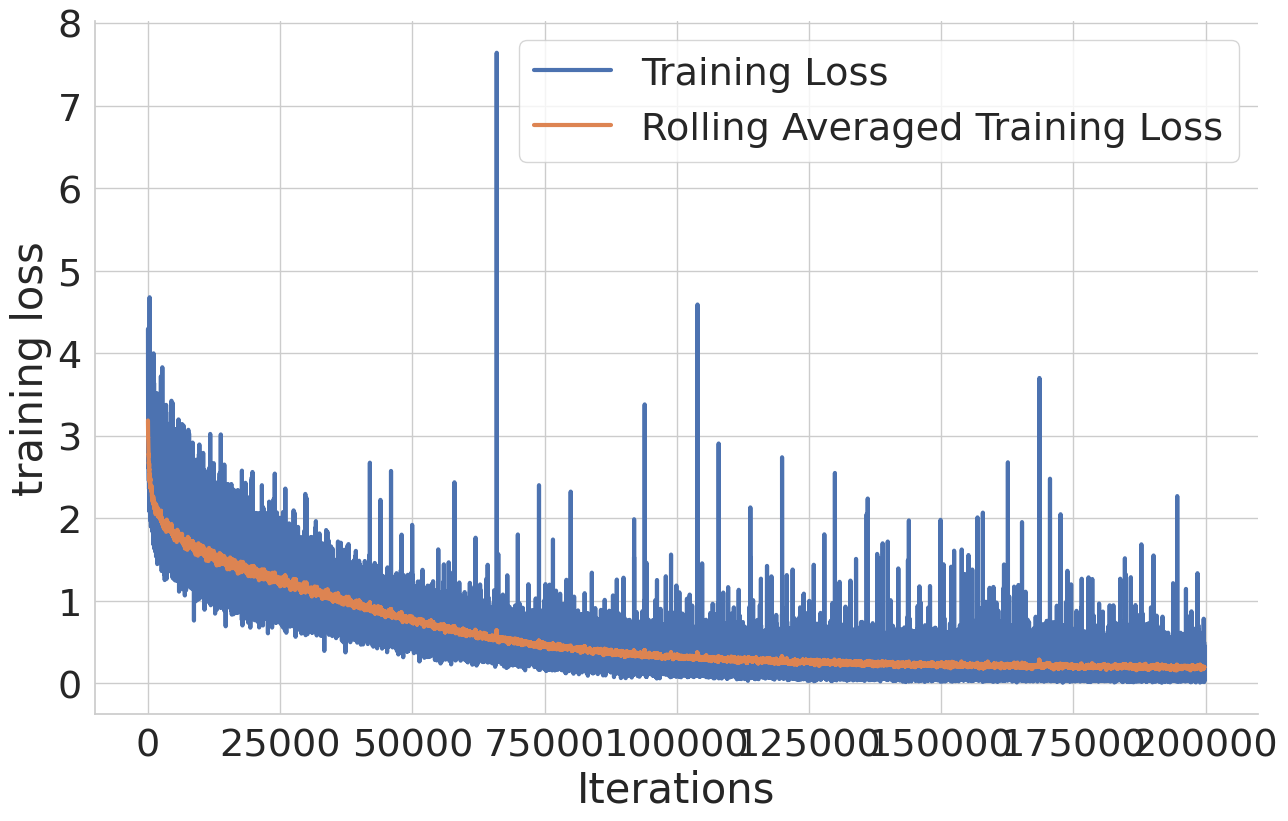

In [28]:
# Plot the training loss and rolling mean training loss with respect to iterations
# Feel free to change the window size
plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100,
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()